In [2]:
import numpy as np
import uproot
import pandas as pd
import awkward as ak

In [3]:
events = uproot.open("/eos/user/d/dasgupsu/NoiseHits_discrimination/vfe-toymc/Signal_Pulses_5GeV.root:PulseData")
branches = events.arrays(events.keys(), library="np")

In [4]:
branches.keys()

dict_keys(['chi2', 'amplitude_true', 'reco_amplitude', 'posIdX', 'eventIdX', 'intime_pulse_idx', 'pulse_shapes', 'bx_values', 'obs_shapes', 'pileup_shapes', 'noise_shapes'])

In [5]:
chi2 = branches["chi2"]
amplitude_true = branches["amplitude_true"]
reco_amplitude = branches["reco_amplitude"]
posIdX = branches["posIdX"]
obs_shapes = branches["obs_shapes"]
pileup_shapes = branches["pileup_shapes"]
noise_shapes = branches["noise_shapes"]
pulse_shapes = branches["pulse_shapes"]

In [6]:
reco_pulse_shapes = pulse_shapes.reshape(-1,11,11,10,10)

In [7]:
total_timeSamples = obs_shapes.reshape(-1,11,11,10)

In [8]:
signal_amp = amplitude_true.reshape(-1,121,1)

In [9]:
reco_signal_amp = reco_amplitude.reshape(-1,121,1)

In [10]:
chi2 = chi2.reshape(-1,121,1)

In [11]:
#Take 5th postion as Engey deposition in the cell
total_timeSamples_amp = total_timeSamples[:,:,:,5]
total_timeSamples_amp = abs(total_timeSamples_amp.reshape(-1,11,11,1))

In [12]:
total_timeSamples_max =  np.max(abs(total_timeSamples), axis=-1, keepdims=True)

In [13]:
#TimeSample is normalized w.r.t max adc count amoung 10 samplepoints
total_timeSamples = total_timeSamples/total_timeSamples_max

In [14]:
import torch
import torch_geometric
from torch_geometric.data import Data
import random
import torch.nn.functional as F

In [15]:
def create_graph(grid, amp_max, amp, reco_amp, reco_pulse, chi2):
    # Grid size
    size = 11
    nodes = size * size
    edges = set()

    # Central cell index
    central_idx = 5 * size + 5

    # Connect central cell to its 8 neighbors
    for i in range(-1, 2):
        for j in range(-1, 2):
            if i == 0 and j == 0:
                continue  # Skip the central cell itself
            neighbor_idx = (5 + i) * size + (5 + j)
            edges.add((central_idx, neighbor_idx))
            edges.add((neighbor_idx, central_idx))  # Undirected graph

    # Connect all other cells to 4 random neighbors
    for x in range(size):
        for y in range(size):
            if x == 5 and y == 5:
                continue  # Skip the central cell
            current_idx = x * size + y
            neighbors = []
            # Get all possible neighbors
            for i in range(-1, 2):
                for j in range(-1, 2):
                    if i == 0 and j == 0:
                        continue  # Skip itself
                    nx, ny = x + i, y + j
                    if 0 <= nx < size and 0 <= ny < size:
                        neighbors.append(nx * size + ny)
            # Randomly select 4 neighbors
            selected_neighbors = random.sample(neighbors, min(8, len(neighbors)))
            for neighbor in selected_neighbors:
                edges.add((current_idx, neighbor))
                edges.add((neighbor, current_idx))  # Undirected graph

    # Convert edges to a tensor
    edge_index = torch.tensor(list(edges), dtype=torch.long).t().contiguous()
    pos_id = np.arange(0,121,1)
    pos_x = pos_id//11
    pos_y = pos_id%11
    position = np.concatenate((0.1*pos_x.reshape(121,1), 0.1*pos_y.reshape(121,1)), axis = 1)
    position = torch.tensor(position, dtype=torch.float)

    # Node features (flatten the grid)
    x = torch.tensor(grid.reshape(-1, 10), dtype=torch.float)
    x = torch.concat((x, position), axis = 1)
    chi2 = torch.tensor(chi2.reshape(-1, 1), dtype=torch.float)
    amp = torch.tensor(amp.reshape(-1, 1), dtype=torch.float)
    reco_amp = torch.tensor(reco_amp.reshape(-1, 1), dtype=torch.float)
    reco_pulse = torch.tensor(reco_pulse.reshape(-1, 10,10), dtype=torch.float)
    amp_max = torch.tensor(abs(amp_max).reshape(-1, 1), dtype=torch.float)
    gobal_amp_max = torch.max(reco_amp, axis = 0)[0]
    norm_amp_max = (reco_amp/gobal_amp_max)
    x = torch.concat((x, norm_amp_max), axis = 1)
    amp_max = abs(amp_max[:, 0])

    data_labels = torch.where(amp != 0, 1, 0)
    data_labels = data_labels.reshape(-1,1)
    
    #edge_attr = torch.sqrt(amp_max[edge_index[0]] * amp_max[edge_index[1]]).unsqueeze(1)
    edge_attr = torch.sum(x[:,:10][edge_index[0]] * x[:,:10][edge_index[1]], dim=1, keepdim=True)
    edge_attr = edge_attr/(amp_max[edge_index[0]] * amp_max[edge_index[1]]).unsqueeze(1)
    # Create the graph data object
    graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, true_amp = amp, y=data_labels, reco_amp = reco_amp, reco_pulse = reco_pulse, chi2 = chi2)
    
    return graph

In [16]:
graphs = []
for i in range(total_timeSamples.shape[0]):
    graphs.append(create_graph(total_timeSamples[i], total_timeSamples_amp[i], signal_amp[i], reco_signal_amp[i], reco_pulse_shapes[i], chi2[i]))

In [17]:
graphs[2].x[59]

tensor([0.5796, 0.3335, 0.2164, 0.1672, 0.4899, 0.6276, 0.5395, 0.5336, 0.6931,
        1.0000, 0.5000, 0.4000, 0.0571])

In [18]:
def create_49_cell_mask(graph, drop_ratio=0.999):
    size = 11
    mask = torch.ones(size * size, dtype=torch.bool)
    
    # Get indices of the 49 central cells
    indices = []
    for i in range(2, 9):  # Rows 2 to 8
        for j in range(2, 9):  # Columns 2 to 8
            indices.append((i * size + j))  
            mask[(i * size + j)] = True
    indices = torch.tensor(indices)
    # Ensure graph.y is 1D
    y_flat = graph.y.squeeze()  # Converts [121, 1] -> [121]

    # Select only signal cells 
    signal_indices = indices[y_flat[indices] == 1]
    # Randomly select 80% of signal cells to drop
    num_drop = int(len(signal_indices) * drop_ratio)
    if num_drop > 0:  
        drop_indices = torch.randperm(len(signal_indices))[:num_drop]  # Random subset
        mask[signal_indices] = True  # Set all signal cells in the 49-region to True
        mask[signal_indices[drop_indices]] = False  # Drop 80% of them

    return mask

In [19]:
from sklearn.model_selection import train_test_split

# First split: train vs temp (val + test)
train_data, temp_data = train_test_split(graphs, test_size=0.3, random_state=42)

# Second split: val vs test (fixed, reproducible)
val_data, test_data = train_test_split(temp_data, test_size=0.7, random_state=42)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")

Training samples: 7000
Validation samples: 900
Test samples: 2100


In [20]:
for graph in train_data:
    graph.mask = create_49_cell_mask(graph, 0.0)
for graph in val_data:
    graph.mask = create_49_cell_mask(graph, 0.0)
for graph in test_data:
    graph.mask = create_49_cell_mask(graph, 0.0)

In [21]:
from torch_geometric.data import DataLoader
batch_size = 64  # Adjust batch size as needed

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last= True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last= True)
test_loader = DataLoader(test_data, shuffle=False, drop_last= True)

/cvmfs/sft.cern.ch/lcg/views/LCG_106a_cuda/x86_64-el9-gcc11-opt/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [22]:
sum1 = torch.tensor(0)
sum2 = torch.tensor(0)
for batch in train_loader:
    sum1 +=(torch.sum((batch.y[batch.mask].flatten() ==1)))
    sum2 +=(torch.sum((batch.y[batch.mask].flatten() !=1)))

In [23]:
print("No. Signal cells", sum1)
print("No. Noisy cells:", sum2)

No. Signal cells tensor(443387)
No. Noisy cells: tensor(400709)


In [99]:
from torch_geometric.utils.undirected import to_undirected
from torch_cluster import knn_graph

In [100]:
from torch_geometric.nn import GCNConv
from torch import nn
import torch

class GCNNodeClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GCNNodeClassifier, self).__init__()
         
        self.temporal_conv1 = torch.nn.Conv1d(in_channels=1, out_channels=10, kernel_size=3, stride=1)
        self.temporal_conv2 = torch.nn.Conv1d(in_channels=10, out_channels=10, kernel_size=2, stride=1)
        self.temporal_fc1 = torch.nn.Linear(70, hidden_dim)
        
        self.convnn1 = GCNConv((hidden_dim+3), 64)
        self.convnn2 = GCNConv(64, 128)
        self.convnn3 = GCNConv(128, 256)  
        
        self.dropout1 = nn.Dropout(0.05)
        self.dropout2 = nn.Dropout(0.05)
        
        self.output = nn.Sequential(
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, 1)                                    
        )

    def forward(self, batch):
        src = batch.x
        batch_indices = batch.batch

        temporal_compt = src[:, :10]
        x = temporal_compt.unsqueeze(1)
        x = self.temporal_conv1(x) 
        x = torch.nn.LeakyReLU()(x)
        x = self.temporal_conv2(x) 
        x = torch.nn.LeakyReLU()(x)
        x = x.reshape(-1, 70)
        x = self.temporal_fc1(x)
        x = torch.nn.LeakyReLU()(x)
        
        spatial_compt = src[:,10:13].clone()
        
        edges = to_undirected(knn_graph(spatial_compt, 25, batch=batch_indices, loop=False))

        x = torch.concat((x, src[:,10:13].reshape(-1,3)), axis = 1)

        x = self.convnn1(x, edges)
        x = torch.nn.LeakyReLU()(x)
        x = self.dropout2(x)
        x = self.convnn2(x, edges)
        x = torch.nn.LeakyReLU()(x)
        x = self.dropout2(x)
        x = self.convnn3(x, edges)
        x = torch.nn.LeakyReLU()(x)
        x = self.dropout2(x)
        embb = x
        x = self.output(embb)
        logits = x.view(-1)
        seed_mask = (src[:, -1] == 1.0)

        logits = logits.clone()        
        logits[seed_mask] = 20.0

        out = torch.sigmoid(logits).unsqueeze(1)

        return out, embb

In [101]:
from torch_scatter import scatter

In [102]:
def Reco_Sigma(out_probs, batch, reco_amp, true_amp):    
    reco_signal_masking = out_probs.clone()  
    true_signal_masking = (true_amp !=0)

    masked_reco = reco_amp * reco_signal_masking
    masked_true = true_amp * true_signal_masking

    reco_sig_energy = scatter(masked_reco, batch, dim=0, reduce='sum')
    true_sig_energy = scatter(masked_true, batch, dim=0, reduce='sum')
    
    reco_sig_sigma = torch.var(reco_sig_energy, axis=0)
    true_sig_sigma = torch.var(true_sig_energy, axis=0)

    return torch.sqrt(reco_sig_sigma), torch.sqrt(true_sig_sigma)

In [103]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [104]:
model = GCNNodeClassifier(13, 32).to(device)

In [98]:
!rm /eos/home-i00/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/GNN/Without_prob/GCN_Conv/*

In [105]:
import os
save_directory = '/eos/home-i00/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/GNN/Without_prob/GCN_Conv/'
os.makedirs(save_directory, exist_ok=True)

In [106]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion1 = torch.nn.BCELoss()

In [107]:
def train():
    model.train()
    total_loss = 0
    loss_recosigma = 0
    loss_truesigma = 0
    
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out, pulse_features = model(batch)
        out, pulse_features = out[batch.mask], pulse_features[batch.mask]
        out_probs = out #torch.sigmoid(out)
        
        target = batch.y[batch.mask].float()

        loss_cls = criterion1(out_probs, target) 
        loss_sigma = Reco_Sigma(out_probs, batch.batch[batch.mask], batch.reco_amp[batch.mask], batch.true_amp[batch.mask]) 
        
        
        loss =  loss_cls + 0.001*loss_sigma[0]

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loss_truesigma += loss_sigma[1]
        loss_recosigma += loss_sigma[0]
        
    print("loss_recosigma --->",(loss_recosigma/ len(train_loader)))   
    return total_loss / len(train_loader)

In [108]:
def validate():
    model.eval()
    total_loss = 0
    loss_recosigma = 0
    loss_truesigma = 0
    
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out, _ = model(batch)
            out = out[batch.mask]
            out_probs = out
            
            target = batch.y[batch.mask].float()
            
            loss_cls = criterion1(out_probs, target)
            
            loss_sigma = Reco_Sigma(out_probs, batch.batch[batch.mask], batch.reco_amp[batch.mask], batch.true_amp[batch.mask])
            
            loss =  loss_cls + 0.001*loss_sigma[0]
            
            total_loss += loss.item()
            
            loss_truesigma += loss_sigma[1]
            loss_recosigma += loss_sigma[0]
    
    print("Valid_loss_recosigma --->",(loss_recosigma/ len(val_loader)))
    return total_loss / len(val_loader)

In [109]:
epochs = 500
train_losses = []
val_losses = []
for epoch in range(1, epochs + 1):
    train_loss = train()
    val_loss = validate()
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    save_path = os.path.join(save_directory, f"Epoch_{epoch}_TrainLoss_{train_loss:.2f}_ValLoss_{val_loss:.2f}.pt")
    torch.save(model.state_dict(), save_path)

    print(f"Epoch {epoch}, TrainLoss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


loss_recosigma ---> tensor([633.6610], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([529.4804], device='cuda:0')
Epoch 1, TrainLoss: 1.4574, Val Loss: 1.3467
loss_recosigma ---> tensor([545.3448], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([472.9812], device='cuda:0')
Epoch 2, TrainLoss: 1.3307, Val Loss: 1.2709
loss_recosigma ---> tensor([492.7765], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([471.0599], device='cuda:0')
Epoch 3, TrainLoss: 1.1861, Val Loss: 1.0989
loss_recosigma ---> tensor([483.2771], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([488.2172], device='cuda:0')
Epoch 4, TrainLoss: 1.1009, Val Loss: 1.0460
loss_recosigma ---> tensor([488.1155], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([450.4561], device='cuda:0')
Epoch 5, TrainLoss: 1.0849, Val Loss: 1.0374
loss_recosigma ---> tensor([490.8933], device='cuda:0', grad_fn=<

loss_recosigma ---> tensor([406.5906], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([453.6099], device='cuda:0')
Epoch 45, TrainLoss: 0.9269, Val Loss: 0.9348
loss_recosigma ---> tensor([403.5743], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([382.2448], device='cuda:0')
Epoch 46, TrainLoss: 0.9127, Val Loss: 0.9300
loss_recosigma ---> tensor([406.6545], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([429.2819], device='cuda:0')
Epoch 47, TrainLoss: 0.9258, Val Loss: 0.9291
loss_recosigma ---> tensor([404.2125], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([415.1367], device='cuda:0')
Epoch 48, TrainLoss: 0.9143, Val Loss: 0.9099
loss_recosigma ---> tensor([400.5588], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([416.3428], device='cuda:0')
Epoch 49, TrainLoss: 0.9190, Val Loss: 0.9105
loss_recosigma ---> tensor([401.4133], device='cuda:0', grad

loss_recosigma ---> tensor([364.9218], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([379.2777], device='cuda:0')
Epoch 89, TrainLoss: 0.8727, Val Loss: 0.9130
loss_recosigma ---> tensor([365.2497], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([409.9004], device='cuda:0')
Epoch 90, TrainLoss: 0.8850, Val Loss: 0.8991
loss_recosigma ---> tensor([362.7011], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([418.7860], device='cuda:0')
Epoch 91, TrainLoss: 0.8685, Val Loss: 0.9261
loss_recosigma ---> tensor([362.0187], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([440.8337], device='cuda:0')
Epoch 92, TrainLoss: 0.8665, Val Loss: 0.9095
loss_recosigma ---> tensor([359.6952], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([389.4516], device='cuda:0')
Epoch 93, TrainLoss: 0.8665, Val Loss: 0.8921
loss_recosigma ---> tensor([359.2618], device='cuda:0', grad

Valid_loss_recosigma ---> tensor([390.0302], device='cuda:0')
Epoch 132, TrainLoss: 0.8564, Val Loss: 0.8930
loss_recosigma ---> tensor([337.6521], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([387.1334], device='cuda:0')
Epoch 133, TrainLoss: 0.8389, Val Loss: 0.8827
loss_recosigma ---> tensor([343.6779], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([386.3401], device='cuda:0')
Epoch 134, TrainLoss: 0.8523, Val Loss: 0.8791
loss_recosigma ---> tensor([337.3446], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([426.3421], device='cuda:0')
Epoch 135, TrainLoss: 0.8407, Val Loss: 0.9000
loss_recosigma ---> tensor([338.6360], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([371.4251], device='cuda:0')
Epoch 136, TrainLoss: 0.8460, Val Loss: 0.8775
loss_recosigma ---> tensor([336.8915], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([357.1454], device='cu

loss_recosigma ---> tensor([321.6039], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([398.0844], device='cuda:0')
Epoch 176, TrainLoss: 0.8223, Val Loss: 0.8746
loss_recosigma ---> tensor([320.6392], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([372.1671], device='cuda:0')
Epoch 177, TrainLoss: 0.8270, Val Loss: 0.8793
loss_recosigma ---> tensor([323.8302], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([367.1871], device='cuda:0')
Epoch 178, TrainLoss: 0.8330, Val Loss: 0.8909
loss_recosigma ---> tensor([317.8574], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([393.6204], device='cuda:0')
Epoch 179, TrainLoss: 0.8216, Val Loss: 0.8796
loss_recosigma ---> tensor([315.1119], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([385.5747], device='cuda:0')
Epoch 180, TrainLoss: 0.8199, Val Loss: 0.8802
loss_recosigma ---> tensor([314.4090], device='cuda:0',

Valid_loss_recosigma ---> tensor([387.7056], device='cuda:0')
Epoch 219, TrainLoss: 0.8098, Val Loss: 0.8685
loss_recosigma ---> tensor([303.5978], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([412.1339], device='cuda:0')
Epoch 220, TrainLoss: 0.8019, Val Loss: 0.8900
loss_recosigma ---> tensor([301.4380], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([401.3867], device='cuda:0')
Epoch 221, TrainLoss: 0.7996, Val Loss: 0.8818
loss_recosigma ---> tensor([306.6243], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([355.9543], device='cuda:0')
Epoch 222, TrainLoss: 0.8141, Val Loss: 0.8898
loss_recosigma ---> tensor([305.5490], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([381.8824], device='cuda:0')
Epoch 223, TrainLoss: 0.8067, Val Loss: 0.8794
loss_recosigma ---> tensor([304.5910], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([375.6837], device='cu

loss_recosigma ---> tensor([294.1562], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([370.0725], device='cuda:0')
Epoch 263, TrainLoss: 0.7916, Val Loss: 0.8686
loss_recosigma ---> tensor([293.7766], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([389.1913], device='cuda:0')
Epoch 264, TrainLoss: 0.7962, Val Loss: 0.8756
loss_recosigma ---> tensor([298.4295], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([399.4493], device='cuda:0')
Epoch 265, TrainLoss: 0.8004, Val Loss: 0.8841
loss_recosigma ---> tensor([294.8639], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([385.7503], device='cuda:0')
Epoch 266, TrainLoss: 0.7949, Val Loss: 0.8704
loss_recosigma ---> tensor([295.4525], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([388.9575], device='cuda:0')
Epoch 267, TrainLoss: 0.7936, Val Loss: 0.8740
loss_recosigma ---> tensor([294.4088], device='cuda:0',

Valid_loss_recosigma ---> tensor([379.8282], device='cuda:0')
Epoch 306, TrainLoss: 0.7776, Val Loss: 0.8774
loss_recosigma ---> tensor([281.7124], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([389.0663], device='cuda:0')
Epoch 307, TrainLoss: 0.7762, Val Loss: 0.8771
loss_recosigma ---> tensor([283.2138], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([357.2129], device='cuda:0')
Epoch 308, TrainLoss: 0.7841, Val Loss: 0.8837
loss_recosigma ---> tensor([283.4164], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([395.5172], device='cuda:0')
Epoch 309, TrainLoss: 0.7783, Val Loss: 0.8763
loss_recosigma ---> tensor([283.4543], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([447.7331], device='cuda:0')
Epoch 310, TrainLoss: 0.7811, Val Loss: 0.9162
loss_recosigma ---> tensor([289.0264], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([387.5781], device='cu

loss_recosigma ---> tensor([274.7165], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([383.1864], device='cuda:0')
Epoch 350, TrainLoss: 0.7696, Val Loss: 0.8763
loss_recosigma ---> tensor([274.6276], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([380.0237], device='cuda:0')
Epoch 351, TrainLoss: 0.7727, Val Loss: 0.8815
loss_recosigma ---> tensor([275.1684], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([383.9914], device='cuda:0')
Epoch 352, TrainLoss: 0.7732, Val Loss: 0.8738
loss_recosigma ---> tensor([274.3287], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([367.7372], device='cuda:0')
Epoch 353, TrainLoss: 0.7700, Val Loss: 0.8781
loss_recosigma ---> tensor([272.9174], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([400.7473], device='cuda:0')
Epoch 354, TrainLoss: 0.7685, Val Loss: 0.8766
loss_recosigma ---> tensor([276.3888], device='cuda:0',

Valid_loss_recosigma ---> tensor([373.0883], device='cuda:0')
Epoch 393, TrainLoss: 0.7690, Val Loss: 0.8697
loss_recosigma ---> tensor([265.3687], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([411.9260], device='cuda:0')
Epoch 394, TrainLoss: 0.7626, Val Loss: 0.8908
loss_recosigma ---> tensor([265.4788], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([398.9939], device='cuda:0')
Epoch 395, TrainLoss: 0.7603, Val Loss: 0.8801
loss_recosigma ---> tensor([265.0776], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([449.5464], device='cuda:0')
Epoch 396, TrainLoss: 0.7569, Val Loss: 0.9258
loss_recosigma ---> tensor([270.0277], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([394.7997], device='cuda:0')
Epoch 397, TrainLoss: 0.7674, Val Loss: 0.8778
loss_recosigma ---> tensor([268.2752], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([376.3061], device='cu

loss_recosigma ---> tensor([255.6573], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([384.7694], device='cuda:0')
Epoch 437, TrainLoss: 0.7481, Val Loss: 0.8741
loss_recosigma ---> tensor([256.5918], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([386.4406], device='cuda:0')
Epoch 438, TrainLoss: 0.7489, Val Loss: 0.8874
loss_recosigma ---> tensor([255.3382], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([399.0739], device='cuda:0')
Epoch 439, TrainLoss: 0.7493, Val Loss: 0.8788
loss_recosigma ---> tensor([256.5460], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([374.8405], device='cuda:0')
Epoch 440, TrainLoss: 0.7512, Val Loss: 0.8789
loss_recosigma ---> tensor([252.9824], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([398.5086], device='cuda:0')
Epoch 441, TrainLoss: 0.7470, Val Loss: 0.8814
loss_recosigma ---> tensor([251.0828], device='cuda:0',

Valid_loss_recosigma ---> tensor([396.7956], device='cuda:0')
Epoch 480, TrainLoss: 0.7373, Val Loss: 0.8916
loss_recosigma ---> tensor([243.8761], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([371.5614], device='cuda:0')
Epoch 481, TrainLoss: 0.7367, Val Loss: 0.8734
loss_recosigma ---> tensor([242.2618], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([383.4761], device='cuda:0')
Epoch 482, TrainLoss: 0.7351, Val Loss: 0.8886
loss_recosigma ---> tensor([243.2216], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([401.8042], device='cuda:0')
Epoch 483, TrainLoss: 0.7364, Val Loss: 0.8879
loss_recosigma ---> tensor([243.8613], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([404.1727], device='cuda:0')
Epoch 484, TrainLoss: 0.7367, Val Loss: 0.8825
loss_recosigma ---> tensor([245.2566], device='cuda:0', grad_fn=<DivBackward0>)
Valid_loss_recosigma ---> tensor([373.9499], device='cu

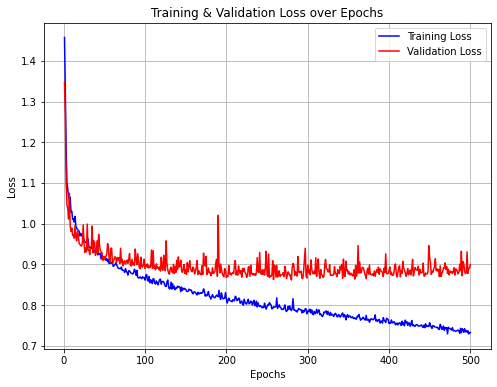

In [110]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(val_losses) + 1), train_losses, label="Training Loss", color="blue")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss over Epochs")
plt.legend()
plt.grid()
plt.show()

In [47]:
best_model = GCNNodeClassifier(13, 32).to(device)
best_model.load_state_dict(torch.load("/eos/home-i00/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/GNN/Without_prob/GCN_Conv_v1/Epoch_425_TrainLoss_0.81_ValLoss_0.94.pt", weights_only=True))
best_model.eval()

GCNNodeClassifier(
  (temporal_conv1): Conv1d(1, 10, kernel_size=(3,), stride=(1,))
  (temporal_conv2): Conv1d(10, 10, kernel_size=(2,), stride=(1,))
  (temporal_fc1): Linear(in_features=70, out_features=32, bias=True)
  (convnn1): GCNConv(35, 64)
  (convnn2): GCNConv(64, 128)
  (convnn3): GCNConv(128, 32)
  (dropout1): Dropout(p=0.15, inplace=False)
  (dropout2): Dropout(p=0.15, inplace=False)
  (output): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [49]:
prediction = ()
true_label = ()
true_energy = ()
reco_energy = ()
reco_chi2 = ()
true_graph = ()
pred_embb_graph = ()
real_hit_pulse_graph = ()
mask = ()
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out, pred_embb = best_model(batch)
        real_hit_indices = (batch.y ==1).nonzero(as_tuple=True)[0]        
        real_hit_pulse_graph+=(pred_embb.reshape(-1,121,32), )
        prediction+=(out.reshape(-1,121,1), )
        true_label+=(batch.y.reshape(-1,121,1).float(), )
        true_energy+=(batch.true_amp.reshape(-1,121,1).float(), )
        reco_energy+=(batch.reco_amp.reshape(-1,121,1).float(), )
        reco_chi2+=(batch.chi2.reshape(-1,121,1).float(), )
        true_graph+= (batch.x.reshape(-1,121,13), )
        mask+= (batch.mask.reshape(-1,121,1), )

In [50]:
predictions = torch.cat(prediction)
predictions = predictions.data.cpu().numpy()
true_labels=torch.cat(true_label)
true_labels = true_labels.data.cpu().numpy()
true_energy = torch.cat(true_energy)
true_energy = true_energy.data.cpu().numpy()
reco_energy = torch.cat(reco_energy)
reco_energy = reco_energy.data.cpu().numpy()
reco_chi2 = torch.cat(reco_chi2)
reco_chi2 = reco_chi2.data.cpu().numpy()
true_graph = torch.cat(true_graph)
true_graph = true_graph.data.cpu().numpy()
real_hit_pulse_graph = torch.cat(real_hit_pulse_graph)
real_hit_pulse_graph = real_hit_pulse_graph.data.cpu().numpy()
mask = torch.cat(mask)
mask = mask.data.cpu().numpy()

In [51]:
sigma_fit = []
mu_fit = []
signal_count = []
bkg_count = []
from scipy.stats import norm
for i in np.arange(0,1,0.01):
    ampl = reco_energy.reshape(-1,121)
    pred = predictions.reshape(-1,121)
    amplitude = np.where(pred > (i), ampl, 0 )
    count1 = np.count_nonzero(amplitude, axis = 1)
    signal_count.append(np.mean(count1))
    bkg_count.append(np.mean(121-count1))
    energy = np.sum(amplitude, axis= 1)
    mu_initial, sigma_initial = norm.fit(energy)
    filtered_data = energy[(energy > (mu_initial - 2* sigma_initial)) & (energy < (mu_initial + 2 * sigma_initial))]
    mu, sigma = norm.fit(filtered_data)
    mu_fit.append(mu)
    sigma_fit.append(sigma)

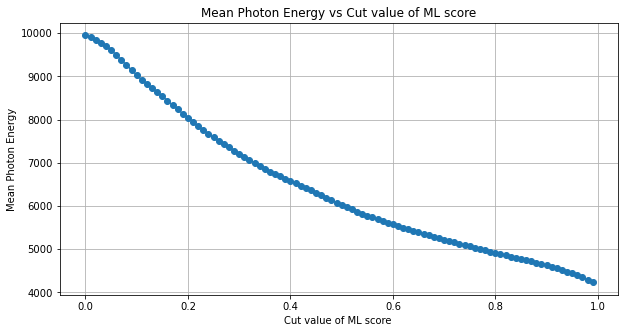

In [52]:
x = np.arange(0,1,0.01)
# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(x, mu_fit, marker='o', linestyle='-')
plt.title("Mean Photon Energy vs Cut value of ML score")
plt.ylabel("Mean Photon Energy")
plt.xlabel("Cut value of ML score ")
plt.grid(True)
#plt.savefig("Plots/Reco_Ecell_Mean_5GeV.png", dpi=300)

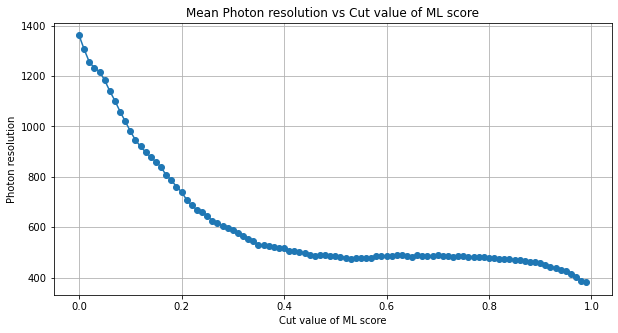

In [53]:
x = np.arange(0,1,0.01)
# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(x, sigma_fit, marker='o', linestyle='-')
plt.title("Mean Photon resolution vs Cut value of ML score")
plt.ylabel("Photon resolution")
plt.xlabel("Cut value of ML score")
plt.grid(True)

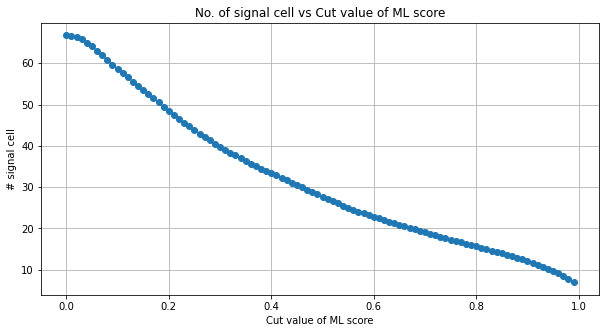

In [54]:
x = np.arange(0,1,0.01)
# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(x, signal_count, marker='o', linestyle='-')
plt.title("No. of signal cell vs Cut value of ML score")
plt.ylabel("# signal cell")
plt.xlabel("Cut value of ML score")
plt.grid(True)

In [55]:
sig_RecoEn = np.copy(reco_energy)
sig_RecoEn = np.where(predictions > 0.5, sig_RecoEn, 0)
sig_RecoEn = np.sum((sig_RecoEn), axis = 1)

In [56]:
amplitude = sig_RecoEn

483.9413


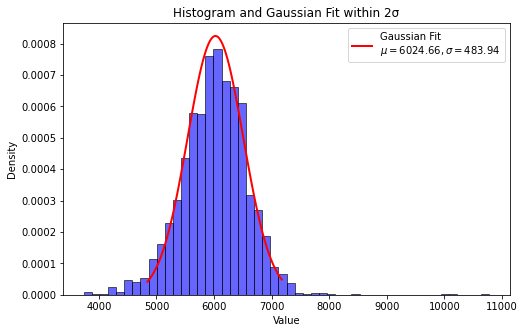

In [57]:
from scipy.stats import norm
# First fit to whole data
mu_initial, sigma_initial = norm.fit(amplitude)

# Select only data within 2 sigma of initial fit
filtered_data = amplitude[(amplitude > (mu_initial - 2* sigma_initial)) & (amplitude < (mu_initial + 2 * sigma_initial))]

# Fit again to filtered data
mu, sigma = norm.fit(filtered_data)

print(sigma)

# Plot histogram of filtered data
plt.figure(figsize=(8, 5))
count, bins, ignored = plt.hist(amplitude, bins=50, density=True, alpha=0.6, color='b', edgecolor='black')

# Plot the fitted Gaussian only within 2σ range
x = np.linspace((mu_initial - 2 * sigma_initial),(mu_initial + 2 * sigma_initial), 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'r', linewidth=2, label=f'Gaussian Fit\n$\mu={mu:.2f}, \sigma={sigma:.2f}$')

# Annotate mean and sigma
#plt.text(mu - 1.5 * sigma, max(p) * 0.8, f"$\mu={mu:.2f}$\n$\sigma={sigma:.2f}$", fontsize=12, color='red')

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Histogram and Gaussian Fit within 2σ')
plt.legend()
plt.show()

In [58]:
# Data manipulation
import pandas as pd # for data manipulation

# Visualization
import plotly.express as px # for data visualization
import matplotlib.pyplot as plt # for showing handwritten digits

# Skleran
from sklearn.datasets import load_digits # for MNIST data
from sklearn.manifold import TSNE # for t-SNE dimensionality reduction

In [76]:
embb_space = real_hit_pulse_graph.reshape(-1,32)
label = true_labels.reshape(-1)

In [77]:
embed = TSNE(
    n_components=2, # default=2, Dimension of the embedded space.
    perplexity=40, # default=30.0, The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms.
    early_exaggeration=12, # default=12.0, Controls how tight natural clusters in the original space are in the embedded space and how much space will be between them. 
    learning_rate=200, # default=200.0, The learning rate for t-SNE is usually in the range [10.0, 1000.0]. If the learning rate is too high, the data may look like a 'ball' with any point approximately equidistant from its nearest neighbours. If the learning rate is too low, most points may look compressed in a dense cloud with few outliers.
    n_iter=5000, # default=1000, Maximum number of iterations for the optimization. Should be at least 250.
    n_iter_without_progress=300, # default=300, Maximum number of iterations without progress before we abort the optimization, used after 250 initial iterations with early exaggeration. 
    min_grad_norm=0.0000001, # default=1e-7, If the gradient norm is below this threshold, the optimization will be stopped.
    metric='euclidean', # default='euclidean', The metric to use when calculating distance between instances in a feature array.
    init='random', # {'random', 'pca'} or ndarray of shape (n_samples, n_components), default='random'. Initialization of embedding
    verbose=2, # default=0, Verbosity level.
    random_state=42, # RandomState instance or None, default=None. Determines the random number generator. Pass an int for reproducible results across multiple function calls.
    method='barnes_hut', # default='barnes_hut'. By default the gradient calculation algorithm uses Barnes-Hut approximation running in O(NlogN) time. method='exact' will run on the slower, but exact, algorithm in O(N^2) time. The exact algorithm should be used when nearest-neighbor errors need to be better than 3%. 
    angle=0.5, # default=0.5, Only used if method='barnes_hut' This is the trade-off between speed and accuracy for Barnes-Hut T-SNE.
    n_jobs=-1, # default=None, The number of parallel jobs to run for neighbors search. -1 means using all processors. 
)

In [78]:
X_embedded = embed.fit_transform(embb_space[:1210])

/cvmfs/sft.cern.ch/lcg/views/LCG_106a_cuda/x86_64-el9-gcc11-opt/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1210 samples in 0.001s...
[t-SNE] Computed neighbors for 1210 samples in 0.034s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1210
[t-SNE] Computed conditional probabilities for sample 1210 / 1210
[t-SNE] Mean sigma: 0.030195
[t-SNE] Computed conditional probabilities in 0.050s
[t-SNE] Iteration 50: error = 63.6904411, gradient norm = 0.0644268 (50 iterations in 0.236s)
[t-SNE] Iteration 100: error = 59.0518875, gradient norm = 0.0351418 (50 iterations in 0.226s)
[t-SNE] Iteration 150: error = 58.2807922, gradient norm = 0.0270275 (50 iterations in 0.197s)
[t-SNE] Iteration 200: error = 58.0134735, gradient norm = 0.0238396 (50 iterations in 0.194s)
[t-SNE] Iteration 250: error = 57.9236946, gradient norm = 0.0262078 (50 iterations in 0.192s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.923695
[t-SNE] Iteration 300: error = 0.7374393, gradient norm = 0.0061655 (50 iterations in 0.189s

[t-SNE] Iteration 4150: error = 0.5530499, gradient norm = 0.0001378 (50 iterations in 0.218s)
[t-SNE] Iteration 4200: error = 0.5530179, gradient norm = 0.0000902 (50 iterations in 0.221s)
[t-SNE] Iteration 4250: error = 0.5529826, gradient norm = 0.0001076 (50 iterations in 0.217s)
[t-SNE] Iteration 4300: error = 0.5528998, gradient norm = 0.0000899 (50 iterations in 0.219s)
[t-SNE] Iteration 4350: error = 0.5529228, gradient norm = 0.0000886 (50 iterations in 0.218s)
[t-SNE] Iteration 4400: error = 0.5528399, gradient norm = 0.0000720 (50 iterations in 0.218s)
[t-SNE] Iteration 4450: error = 0.5528933, gradient norm = 0.0000551 (50 iterations in 0.221s)
[t-SNE] Iteration 4500: error = 0.5528139, gradient norm = 0.0000916 (50 iterations in 0.218s)
[t-SNE] Iteration 4550: error = 0.5527589, gradient norm = 0.0001191 (50 iterations in 0.220s)
[t-SNE] Iteration 4600: error = 0.5528004, gradient norm = 0.0000596 (50 iterations in 0.219s)
[t-SNE] Iteration 4650: error = 0.5527666, gradien

In [79]:
import plotly.express as px
import pandas as pd

# Create a DataFrame with the t-SNE results
df = pd.DataFrame({
    "Dimension 1": X_embedded[:, 0],
    "Dimension 2": X_embedded[:, 1],
    "label": label[:1210].astype(str)  # Convert labels to strings for categorical coloring
})

# Scatter plot with adjustable opacity
fig = px.scatter(
    df, x="Dimension 1", y="Dimension 2", color="label",
    labels={"x": "Dimension 1", "y": "Dimension 2"},
    opacity=0.5  # Adjust opacity to make overlapping points visible
)

# Change chart background color
fig.update_layout(plot_bgcolor='white')

# Update axes lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey',
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
                 showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey',
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
                 showline=True, linewidth=1, linecolor='black')

# Set figure title
fig.update_layout(title_text="t-SNE Visualization")

# Update marker properties to make overlapping points more visible
fig.update_traces(marker=dict(size=4, opacity=0.6, line=dict(width=0.5, color='black')))

fig.show()


/cvmfs/sft.cern.ch/lcg/views/LCG_106a_cuda/x86_64-el9-gcc11-opt/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [63]:
signal_cry_index =  np.where(true_labels != 0)
noise_cry_index =  np.where(true_labels == 0)

In [64]:
true_mask = mask[signal_cry_index] 

mask_signal_cry_index = tuple(idx[true_mask] for idx in signal_cry_index)

In [65]:
false_mask = mask[noise_cry_index]  

mask_noise_cry_index = tuple(idx[false_mask] for idx in noise_cry_index)

In [66]:
sig_graph = true_graph[signal_cry_index[0], signal_cry_index[1]][true_mask]
noise_graph = true_graph[noise_cry_index[0], noise_cry_index[1]][false_mask]

In [67]:
x_cord1, y_cord1 = sig_graph[:,10], sig_graph[:,11]

In [68]:
x_cord2, y_cord2 = noise_graph[:,10], noise_graph[:,11]

In [69]:
dist1 = np.square(10*x_cord1- 5) + np.square(10*y_cord1- 5)
dist1 = np.sqrt(dist1)

In [70]:
dist2 = np.square(10*x_cord2- 5) + np.square(10*y_cord2- 5)
dist2 = np.sqrt(dist2)

In [71]:
sig_preds = predictions[signal_cry_index][true_mask]
bkg_preds = predictions[noise_cry_index][false_mask]

In [72]:
sig_energy = true_energy[signal_cry_index][true_mask]
noise_energy = true_energy[noise_cry_index][false_mask]

In [73]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

(120759,)
(133341,)


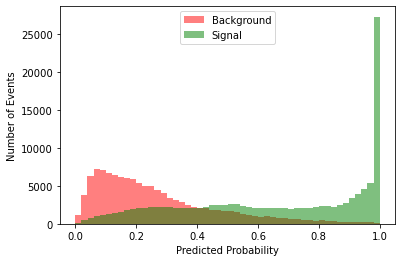

In [74]:
print(bkg_preds.shape)
print(sig_preds.shape)
# Plot the predicted probabilities
plt.hist(bkg_preds, bins=50, label='Background', alpha=0.5,  color='r')
plt.hist(sig_preds, bins=50, label='Signal', alpha=0.5, color='green')
#plt.xscale('log')  # Set x-axis to logarithmic scale
#plt.yscale('log')  # Uncomment to set y-axis to logarithmic scale instead
plt.xlabel('Predicted Probability')
plt.ylabel('Number of Events')
plt.legend(loc='upper center')
#plt.ylim(top=100)
plt.show()

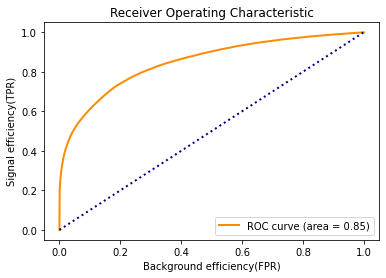

In [75]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels[mask], predictions[mask])
roc_auc = auc(fpr, tpr)

# Plot ROC curve

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle=':')
plt.xlabel('Background efficiency(FPR)')
plt.ylabel('Signal efficiency(TPR)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

/cvmfs/sft.cern.ch/lcg/views/LCG_106a_cuda/x86_64-el9-gcc11-opt/lib/python3.11/site-packages/mpl_toolkits/mplot3d/art3d.py:1228: RuntimeWarning:

divide by zero encountered in divide



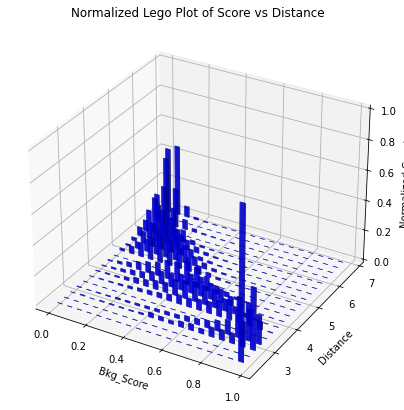

In [80]:
A =  dist2 # Scores (Example: Random values between 0 and 1)
B = bkg_preds  # Distances (Example: Random values between 0 and 10)

# Create histogram bins
bins_x = np.linspace(B.min(), B.max(), 20)  # 20 bins for distance
bins_y = np.linspace(A.min(), A.max(), 20)  # 20 bins for score

# Compute histogram
hist, x_edges, y_edges = np.histogram2d(B, A, bins=[bins_x, bins_y])

# Normalize along A (score bins)
hist_sum = hist.sum(axis=0, keepdims=True)  # Sum over distances for each score bin
hist_normalized = np.divide(hist, hist_sum, where=hist_sum > 0)  # Avoid division by zero

# Create figure and 3D axis
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Prepare 3D bar positions
xpos, ypos = np.meshgrid(x_edges[:-1], y_edges[:-1], indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)

# Bar dimensions
dx = dy = (bins_x[1] - bins_x[0]) / 2  # Adjust bin width
dz = hist_normalized.ravel()  # Height of bars (normalized counts)

# Plot 3D histogram (Lego plot)
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=True, color='b', alpha=0.7)

# Labels
ax.set_xlabel("Bkg_Score")
ax.set_ylabel("Distance")
ax.set_zlabel("Normalized Counts")
ax.set_title("Normalized Lego Plot of Score vs Distance")

plt.show()

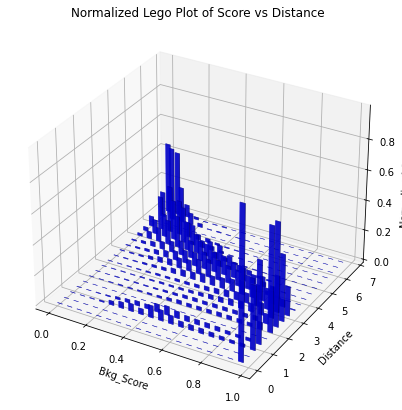

In [81]:
A =  dist1 # Scores (Example: Random values between 0 and 1)
B = sig_preds  # Distances (Example: Random values between 0 and 10)

# Create histogram bins
bins_x = np.linspace(B.min(), B.max(), 20)  # 20 bins for distance
bins_y = np.linspace(A.min(), A.max(), 20)  # 20 bins for score

# Compute histogram
hist, x_edges, y_edges = np.histogram2d(B, A, bins=[bins_x, bins_y])

# Normalize along A (score bins)
hist_sum = hist.sum(axis=0, keepdims=True)  # Sum over distances for each score bin
hist_normalized = np.divide(hist, hist_sum, where=hist_sum > 0)  # Avoid division by zero

# Create figure and 3D axis
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Prepare 3D bar positions
xpos, ypos = np.meshgrid(x_edges[:-1], y_edges[:-1], indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)

# Bar dimensions
dx = dy = (bins_x[1] - bins_x[0]) / 2  # Adjust bin width
dz = hist_normalized.ravel()  # Height of bars (normalized counts)

# Plot 3D histogram (Lego plot)
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=True, color='b', alpha=0.7)

# Labels
ax.set_xlabel("Bkg_Score")
ax.set_ylabel("Distance")
ax.set_zlabel("Normalized Counts")
ax.set_title("Normalized Lego Plot of Score vs Distance")

plt.show()

In [84]:
batch = test_data[341]
with torch.no_grad():
    batch = batch.to(device)
    pred = best_model(batch)
    pred1 = pred[0] #torch.nn.Sigmoid()(pred[0])

In [85]:
    predic1 = torch.zeros_like(pred1)
    energy = torch.zeros_like(batch.true_amp)
    label = torch.zeros_like(batch.y)
    for i in range(len(batch.true_amp)):
        #predic[batch.inverse_map[i]] = pred[i]
        #energy[batch.inverse_map[i]] = batch.energy_amp[i]
        #label[batch.inverse_map[i]] = batch.y[i,0]
        predic1[i] = pred1[i]
        energy[i] = batch.true_amp[i]
        label[i] = batch.y[i,0]

In [86]:
predic1 = predic1.data.cpu().numpy()[:,0].reshape(11,11)
energy = energy.data.cpu().numpy()[:,0].reshape(11,11)
label = label.data.cpu().numpy()[:,0].reshape(11,11)

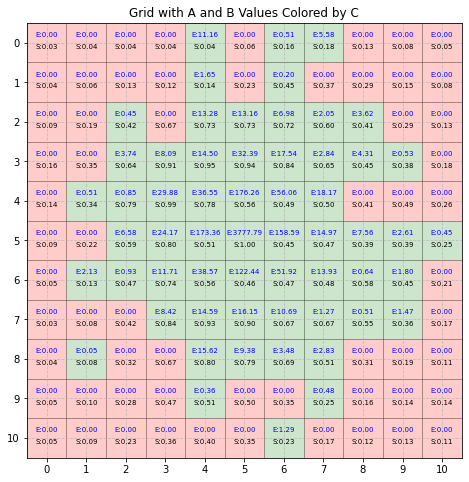

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Example arrays (replace these with your actual A, B, C arrays)
A =predic1
B = energy
C = label  # Random 0 or 1 for demo

plt.figure(figsize=(8, 8))
ax = plt.gca()

# Draw grid and colored cells based on C
for i in range(11):
    for j in range(11):
        color = 'green' if C[i, j] == 1 else 'red'
        rect = patches.Rectangle(
            (j - 0.5, i - 0.5), 1, 1,
            linewidth=1, edgecolor='black',
            facecolor=color, alpha=0.2
        )
        ax.add_patch(rect)

        # Write values of A and B inside the cell
        plt.text(j, i + 0.15, f"S:{A[i, j]:.2f}", fontsize=7, color='black', ha='center')
        plt.text(j, i - 0.15, f"E:{B[i, j]:.2f}", fontsize=7, color='blue', ha='center')

# Set grid properties
plt.xlim(-0.5, 10.5)
plt.ylim(-0.5, 10.5)
plt.xticks(np.arange(11))
plt.yticks(np.arange(11))
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis()  # Invert y-axis to match matrix indexing
plt.title('Grid with A and B Values Colored by C')
plt.show()

In [ ]:
timeSamples0 = batch.x[63][:10].data.cpu().numpy()

In [ ]:
x = np.arange(len(timeSamples0))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x, timeSamples0, marker='o', linestyle='-', color='b', label="Signal Data")
plt.xlabel("Time samplepoint")
plt.ylabel("Normalize_Energy")
#plt.title("Signal Points")
plt.legend(ncol=3, fontsize=6, loc="upper left", bbox_to_anchor=(1.05, 1), 
           borderaxespad=0., markerscale=0.5, handlelength=1.5, frameon=True)

# Adjust layout
plt.tight_layout()

plt.grid(True)